# Compare Quasi-Clique Partition Algorithms

This notebook compares different quasi-clique finding methods from `partition_graph_quasi_clique.py`:
1. **Greedy** - Greedy algorithm for finding quasi-cliques
2. **Branch and Bound** - Exact algorithm using branch-and-bound search
3. **Gurobi** - Exact MIQP formulation using Gurobi optimizer
4. **RLS (Reactive Local Search)** - Heuristic search with tabu and restart

All methods use the same partition strategy: recursively find K-1 quasi-cliques with edge density >= gamma, then assign remaining nodes to the last cluster.

Metrics evaluated:
- IIA (Interchange Intervention Accuracy) per cluster
- Cluster sizes and distributions
- Runtime performance
- Overall graph statistics

In [1]:
import os
import sys
import pickle
import json
import time
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from tqdm import tqdm

# Add hypothesis_testing to path
_script_dir = Path(".").resolve()
if str(_script_dir) not in sys.path:
    sys.path.insert(0, str(_script_dir))

from partition_graph_quasi_clique import (
    quasi_clique_partition,
    compute_edge_density,
    compute_overall_iia,
    compute_subgraph_iia,
)

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

/home/jytan12/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## 1. Load Graph and Dataset

In [2]:
# Configuration
DATASET_PATH = "filtered_input_samples_filling_liquids_15_10_512_google_gemma-2-2b-it.pkl"
GRAPH_PATH =  "graph_filling_liquids_15_10_512_google_gemma-2-2b-it.pkl"
K = 2  # Number of clusters
GAMMA = 0.9  # Minimum edge density for quasi-clique
MIN_CLIQUE_SIZE = 2  # Minimum size for a quasi-clique

# RLS parameters
RLS_MAX_STEPS = 5000
RLS_SEED = 42

# Gurobi parameters (if available)
GUROBI_TIME_LIMIT = 1200  # seconds per quasi-clique

# Limit graph size (BnB cannot handle large graphs)
MAX_NODES = 200  # Subsample to this many nodes; use None to keep full graph

# All quasi-clique methods available
QUASI_CLIQUE_METHODS = ['greedy', 'rls', 'branch_and_bound']

In [3]:
# Try to find the dataset file
base_dir = Path(".").resolve()
possible_paths = [
    base_dir / DATASET_PATH,
    base_dir / "partition_results" / DATASET_PATH,
    base_dir.parent / "partition_results" / DATASET_PATH,
]

dataset_path = None
for path in possible_paths:
    if path.exists():
        dataset_path = path
        print(f"Found dataset at: {dataset_path}")
        break

if dataset_path is None:
    print(f"Dataset not found. Please update DATASET_PATH.")
    print(f"Searched in: {possible_paths}")
else:
    # Load dataset
    with open(dataset_path, 'rb') as f:
        samples = pickle.load(f)
    print(f"Loaded {len(samples)} samples")
    
    # Try to find corresponding graph file
    graph_name = dataset_path.stem.replace("filtered_input_samples_", "graph_")
    graph_paths = [
        dataset_path.parent / f"{graph_name}.pkl",
        dataset_path.parent / "graph.pkl",
        base_dir / f"{graph_name}.pkl",
        base_dir / "graph.pkl",
    ]
    
    graph_path = None
    for gp in graph_paths:
        if gp.exists():
            graph_path = gp
            print(f"Found graph at: {graph_path}")
            break
    
    if graph_path is None:
        print(f"Graph not found. You may need to build it first using partition_graph.py")
        print(f"Searched for: {graph_paths}")

Found dataset at: /home/jytan12/causal_abs_cs224n/Multi_Variable_Causal_Abstraction/Entity_Binding/hypothesis_testing/partition_results/filtered_input_samples_filling_liquids_15_10_512_google_gemma-2-2b-it.pkl
Loaded 507 samples
Found graph at: /home/jytan12/causal_abs_cs224n/Multi_Variable_Causal_Abstraction/Entity_Binding/hypothesis_testing/partition_results/graph_filling_liquids_15_10_512_google_gemma-2-2b-it.pkl


In [4]:
# Load graph if available
if 'graph_path' in locals() and graph_path and graph_path.exists():
    with open(graph_path, 'rb') as f:
        adj_matrix = pickle.load(f)
    adj_matrix = np.asarray(adj_matrix, dtype=bool)
    
    # Ensure it's symmetric (undirected)
    if not np.array_equal(adj_matrix, adj_matrix.T):
        print("Warning: Graph is directed. Converting to undirected (bidirectional edges only).")
        adj_matrix = np.logical_and(adj_matrix, adj_matrix.T)
    
    n_nodes = adj_matrix.shape[0]
    n_edges = np.sum(adj_matrix) // 2
    
    # Subsample to MAX_NODES so BnB can handle the graph
    if MAX_NODES is not None and n_nodes > MAX_NODES:
        rng = np.random.default_rng(42)
        node_indices = rng.choice(n_nodes, size=MAX_NODES, replace=False)
        node_indices = np.sort(node_indices)
        adj_matrix = adj_matrix[np.ix_(node_indices, node_indices)]
        n_nodes = adj_matrix.shape[0]
        n_edges = int(np.sum(adj_matrix) // 2)
        if 'samples' in locals():
            samples = [samples[i] for i in node_indices]
        print(f"Subsampled to {n_nodes} nodes (MAX_NODES={MAX_NODES}) for BnB tractability.")
    
    print(f"Graph loaded: {n_nodes} nodes, {n_edges} edges")
    print(f"Edge density: {compute_overall_iia(adj_matrix):.3f}")
    
    if 'samples' in locals() and len(samples) != n_nodes:
        print(f"Warning: Dataset size ({len(samples)}) != graph size ({n_nodes})")
        print(f"Using first {min(len(samples), n_nodes)} samples")
        samples = samples[:n_nodes]
else:
    print("Graph not loaded. Please provide a graph file or build it first.")
    adj_matrix = None

Subsampled to 200 nodes (MAX_NODES=200) for BnB tractability.
Graph loaded: 200 nodes, 4917 edges
Edge density: 0.247


## 2. Run All Quasi-Clique Methods

In [ ]:
if adj_matrix is None:
    raise ValueError("Graph not loaded. Cannot run partition algorithms.")

results = {}
runtimes = {}

print("Running quasi-clique partition methods...")
print("=" * 70)
print(f"Configuration: K={K}, gamma={GAMMA}, min_clique_size={MIN_CLIQUE_SIZE}")
print("=" * 70)

# Run each quasi-clique method
for method in QUASI_CLIQUE_METHODS:
    print(f"\n{method.upper()}:")
    print("-" * 70)
    
    start_time = time.time()
    
    try:
        # Prepare method-specific kwargs
        method_kwargs = {}
        if method == 'rls':
            method_kwargs['max_steps'] = RLS_MAX_STEPS
            method_kwargs['seed'] = RLS_SEED
        elif method == 'gurobi':
            method_kwargs['time_limit'] = GUROBI_TIME_LIMIT
        elif method == 'branch_and_bound':
            method_kwargs['time_limit'] = GUROBI_TIME_LIMIT
        
        # Run partition
        labels = quasi_clique_partition(
            adj_matrix, 
            K, 
            GAMMA, 
            min_clique_size=MIN_CLIQUE_SIZE,
            method=method,
            **method_kwargs
        )
        
        elapsed_time = time.time() - start_time
        runtimes[method] = elapsed_time
        results[method] = labels
        
        # Quick summary
        unique_labels = np.unique(labels)
        cluster_sizes = [np.sum(labels == k) for k in unique_labels]
        print(f"  ✓ Completed in {elapsed_time:.2f} seconds")
        print(f"  ✓ Found {len(unique_labels)} clusters")
        print(f"  ✓ Cluster sizes: {cluster_sizes}")
        
    except ImportError as e:
        print(f"  ✗ Skipped: {e}")
        print(f"    (Required dependency not installed)")
    except Exception as e:
        print(f"  ✗ Failed: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "=" * 70)
print(f"Completed {len(results)}/{len(QUASI_CLIQUE_METHODS)} methods")
if runtimes:
    print(f"\nRuntime summary:")
    for method, rt in sorted(runtimes.items(), key=lambda x: x[1]):
        print(f"  {method:20s}: {rt:6.2f}s")

Running quasi-clique partition methods...
Configuration: K=2, gamma=0.9, min_clique_size=2

GREEDY:
----------------------------------------------------------------------
Finding 1 quasi-cliques with gamma >= 0.9 (method=greedy)...
  Finding quasi-clique 1/1 (from 200 available nodes)...
    Found quasi-clique 1: size=67, density=0.906
  Assigning 133 remaining nodes to cluster 1...
  ✓ Completed in 0.93 seconds
  ✓ Found 2 clusters
  ✓ Cluster sizes: [67, 133]

RLS:
----------------------------------------------------------------------
Finding 1 quasi-cliques with gamma >= 0.9 (method=rls)...
  Finding quasi-clique 1/1 (from 200 available nodes)...
    Found quasi-clique 1: size=67, density=0.906
  Assigning 133 remaining nodes to cluster 1...
  ✓ Completed in 4.21 seconds
  ✓ Found 2 clusters
  ✓ Cluster sizes: [67, 133]

BRANCH_AND_BOUND:
----------------------------------------------------------------------
Finding 1 quasi-cliques with gamma >= 0.9 (method=branch_and_bound)...
  Fi

## 3. Evaluate Results

In [ ]:
def evaluate_partition(adj_matrix: np.ndarray, labels: np.ndarray, method_name: str) -> Dict:
    """Evaluate a partition and return metrics."""
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    # Cluster sizes
    cluster_sizes = [np.sum(labels == k) for k in unique_labels]
    
    # IIA per cluster
    iia_by_cluster = {}
    for k in unique_labels:
        iia = compute_subgraph_iia(adj_matrix, labels, int(k))
        iia_by_cluster[int(k)] = iia
    
    # Average IIA
    avg_iia = np.mean(list(iia_by_cluster.values()))
    
    # Weighted average IIA (by cluster size)
    weighted_avg_iia = np.average(
        list(iia_by_cluster.values()),
        weights=cluster_sizes
    )
    
    # Min and max cluster sizes
    min_size = min(cluster_sizes) if cluster_sizes else 0
    max_size = max(cluster_sizes) if cluster_sizes else 0
    
    return {
        'method': method_name,
        'n_clusters': n_clusters,
        'cluster_sizes': cluster_sizes,
        'iia_by_cluster': iia_by_cluster,
        'avg_iia': avg_iia,
        'weighted_avg_iia': weighted_avg_iia,
        'min_cluster_size': min_size,
        'max_cluster_size': max_size,
        'size_std': np.std(cluster_sizes) if cluster_sizes else 0,
    }


# Evaluate all methods
evaluations = {}
for method_name, labels in results.items():
    evaluations[method_name] = evaluate_partition(adj_matrix, labels, method_name)
    if method_name in runtimes:
        evaluations[method_name]['runtime'] = runtimes[method_name]
    
print("Evaluation Summary:")
print("=" * 80)
for method_name, eval_result in evaluations.items():
    print(f"\n{method_name}:")
    print(f"  Clusters: {eval_result['n_clusters']}")
    print(f"  Cluster sizes: {eval_result['cluster_sizes']}")
    print(f"  Average IIA: {eval_result['avg_iia']:.3f}")
    print(f"  Weighted avg IIA: {eval_result['weighted_avg_iia']:.3f}")
    print(f"  Size std: {eval_result['size_std']:.2f}")
    if 'runtime' in eval_result:
        print(f"  Runtime: {eval_result['runtime']:.2f}s")

Evaluation Summary:

greedy:
  Clusters: 2
  Cluster sizes: [58, 92]
  Average IIA: 0.487
  Weighted avg IIA: 0.393
  Size std: 17.00
  Runtime: 0.59s

rls:
  Clusters: 2
  Cluster sizes: [58, 92]
  Average IIA: 0.486
  Weighted avg IIA: 0.392
  Size std: 17.00
  Runtime: 2.86s

branch_and_bound:
  Clusters: 2
  Cluster sizes: [57, 93]
  Average IIA: 0.490
  Weighted avg IIA: 0.391
  Size std: 18.00
  Runtime: 600.00s

gurobi:
  Clusters: 1
  Cluster sizes: [150]
  Average IIA: 0.261
  Weighted avg IIA: 0.261
  Size std: 0.00
  Runtime: 601.38s


## 4. Visualizations

/tmp/ipykernel_1538264/535789170.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=45, ha='right')
/tmp/ipykernel_1538264/535789170.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(iia_data, labels=methods, patch_artist=True)
/tmp/ipykernel_1538264/535789170.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=45, ha='right')


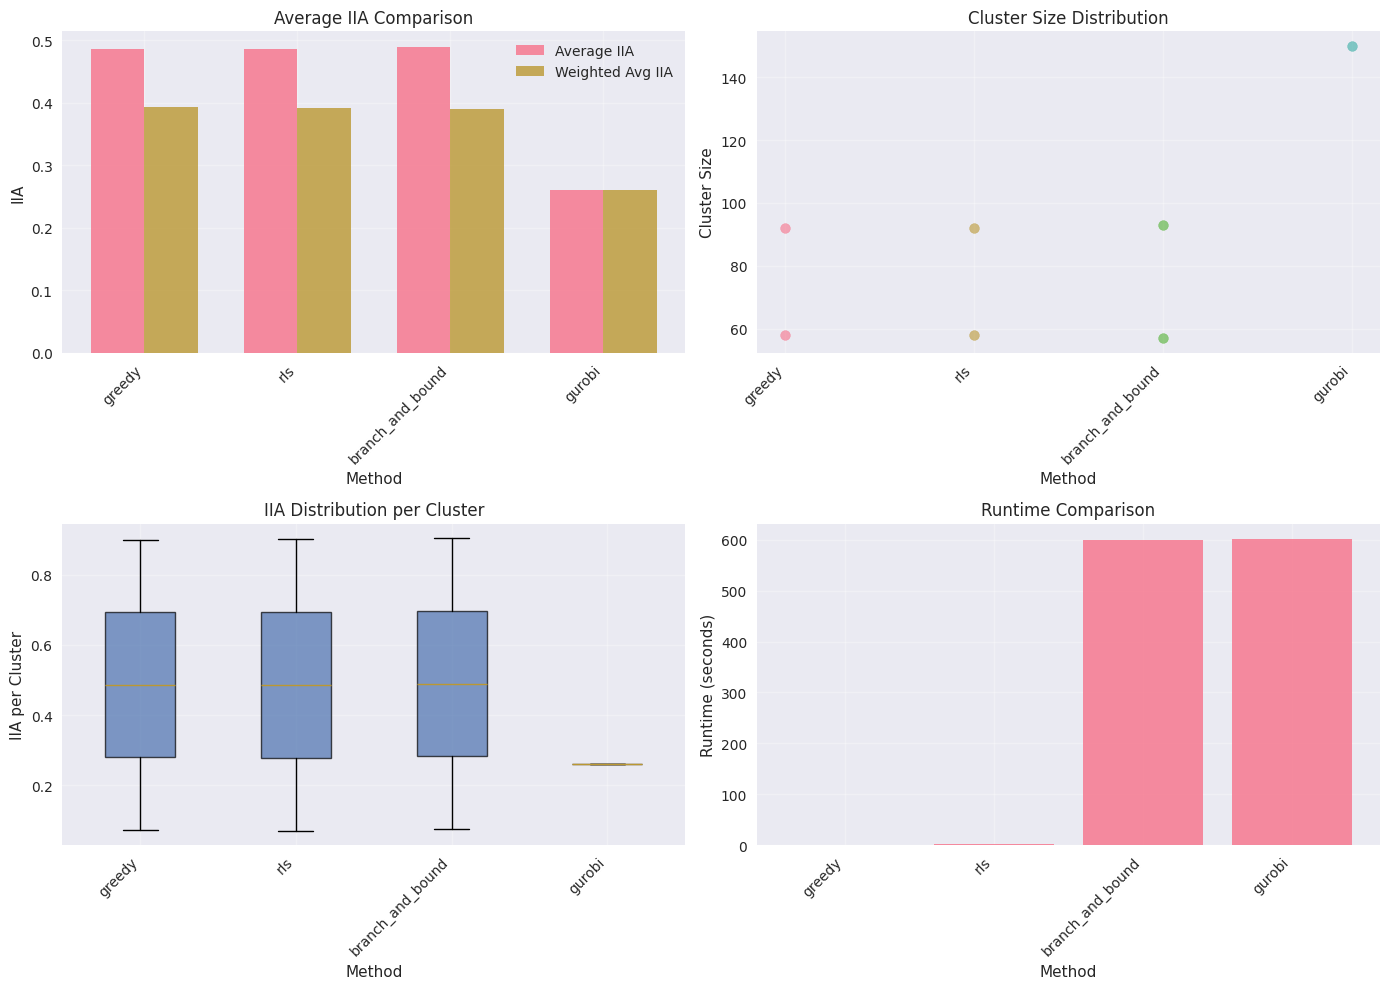

In [7]:
# 1. Compare average IIA across methods
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Average IIA
ax = axes[0, 0]
methods = list(evaluations.keys())
avg_iias = [evaluations[m]['avg_iia'] for m in methods]
weighted_iias = [evaluations[m]['weighted_avg_iia'] for m in methods]

x = np.arange(len(methods))
width = 0.35
ax.bar(x - width/2, avg_iias, width, label='Average IIA', alpha=0.8)
ax.bar(x + width/2, weighted_iias, width, label='Weighted Avg IIA', alpha=0.8)
ax.set_xlabel('Method')
ax.set_ylabel('IIA')
ax.set_title('Average IIA Comparison')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Cluster size distribution
ax = axes[0, 1]
for method_name in methods:
    sizes = evaluations[method_name]['cluster_sizes']
    ax.scatter([method_name] * len(sizes), sizes, alpha=0.6, s=50)
ax.set_xlabel('Method')
ax.set_ylabel('Cluster Size')
ax.set_title('Cluster Size Distribution')
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# IIA per cluster (box plot)
ax = axes[1, 0]
iia_data = [list(evaluations[m]['iia_by_cluster'].values()) for m in methods]
bp = ax.boxplot(iia_data, labels=methods, patch_artist=True)
for patch in bp['boxes']:
    patch.set_alpha(0.7)
ax.set_xlabel('Method')
ax.set_ylabel('IIA per Cluster')
ax.set_title('IIA Distribution per Cluster')
ax.set_xticklabels(methods, rotation=45, ha='right')
ax.grid(True, alpha=0.3)

# Runtime comparison
ax = axes[1, 1]
runtimes_list = [evaluations[m].get('runtime', 0) for m in methods]
if any(runtimes_list):
    ax.bar(methods, runtimes_list, alpha=0.8)
    ax.set_xlabel('Method')
    ax.set_ylabel('Runtime (seconds)')
    ax.set_title('Runtime Comparison')
    ax.set_xticklabels(methods, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No runtime data', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Runtime Comparison')

plt.tight_layout()
plt.show()

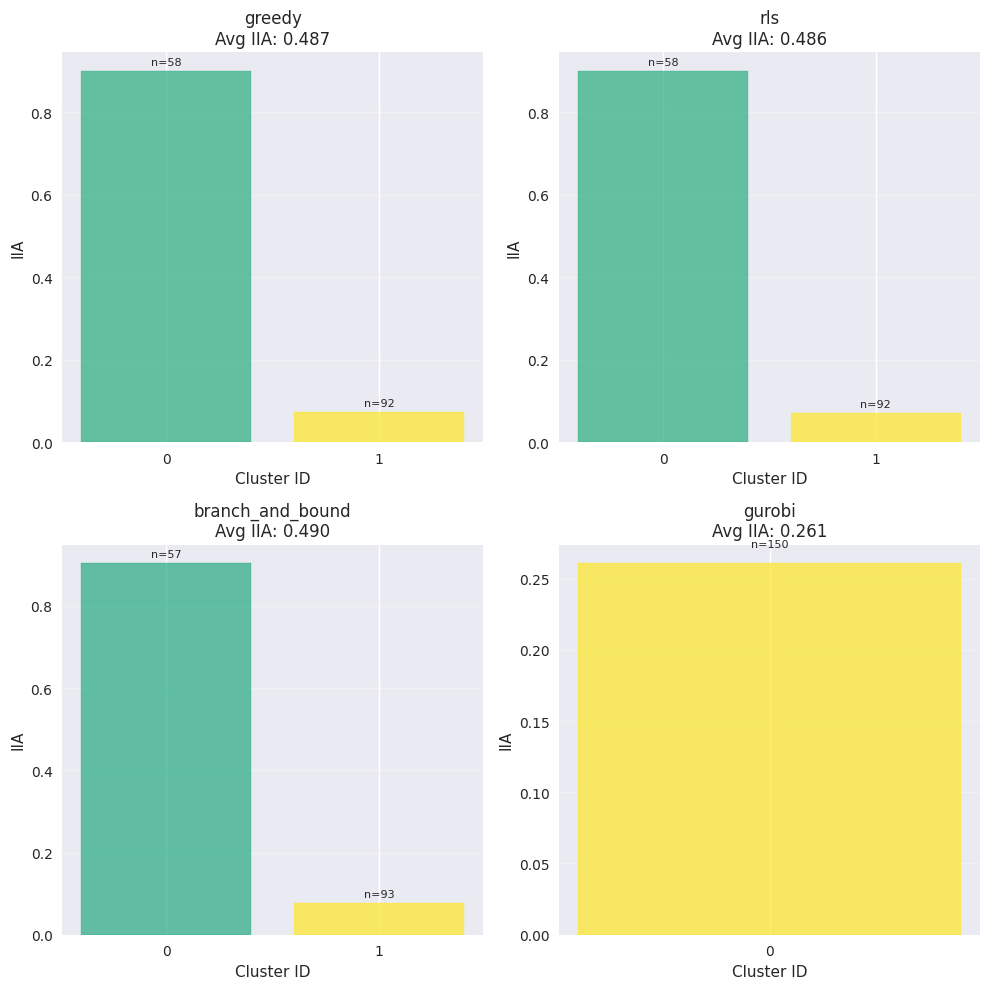

In [8]:
# 2. Detailed IIA per cluster for each method
n_methods = len(evaluations)
fig, axes = plt.subplots(2, (n_methods + 1) // 2, figsize=(5 * ((n_methods + 1) // 2), 10))
if n_methods == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, (method_name, eval_result) in enumerate(evaluations.items()):
    ax = axes[idx] if n_methods > 1 else axes[0]
    
    iia_by_cluster = eval_result['iia_by_cluster']
    cluster_ids = sorted(iia_by_cluster.keys())
    iia_values = [iia_by_cluster[k] for k in cluster_ids]
    cluster_sizes = [eval_result['cluster_sizes'][cluster_ids.index(k)] for k in cluster_ids]
    
    bars = ax.bar(range(len(cluster_ids)), iia_values, alpha=0.7)
    
    # Color bars by cluster size
    if cluster_sizes:
        max_size = max(cluster_sizes)
        for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
            bar.set_color(plt.cm.viridis(size / max_size))
    
    ax.set_xlabel('Cluster ID')
    ax.set_ylabel('IIA')
    ax.set_title(f'{method_name}\nAvg IIA: {eval_result["avg_iia"]:.3f}')
    ax.set_xticks(range(len(cluster_ids)))
    ax.set_xticklabels(cluster_ids)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add cluster sizes as text
    for i, (cluster_id, size) in enumerate(zip(cluster_ids, cluster_sizes)):
        ax.text(i, iia_values[i] + 0.01, f'n={size}', ha='center', va='bottom', fontsize=8)

# Hide unused subplots
for idx in range(n_methods, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# 3. Comparison table
import pandas as pd

comparison_data = []
for method_name, eval_result in evaluations.items():
    row = {
        'Method': method_name,
        'N Clusters': eval_result['n_clusters'],
        'Avg IIA': f"{eval_result['avg_iia']:.3f}",
        'Weighted Avg IIA': f"{eval_result['weighted_avg_iia']:.3f}",
        'Min Size': eval_result['min_cluster_size'],
        'Max Size': eval_result['max_cluster_size'],
        'Size Std': f"{eval_result['size_std']:.2f}",
        'Cluster Sizes': str(eval_result['cluster_sizes']),
    }
    if 'runtime' in eval_result:
        row['Runtime (s)'] = f"{eval_result['runtime']:.2f}"
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)
print("\nComparison Table:")
print("=" * 100)
print(df_comparison.to_string(index=False))


Comparison Table:
          Method  N Clusters Avg IIA Weighted Avg IIA  Min Size  Max Size Size Std Cluster Sizes Runtime (s)
          greedy           2   0.487            0.393        58        92    17.00      [58, 92]        0.59
             rls           2   0.486            0.392        58        92    17.00      [58, 92]        2.86
branch_and_bound           2   0.490            0.391        57        93    18.00      [57, 93]      600.00
          gurobi           1   0.261            0.261       150       150     0.00         [150]      601.38


## 5. Save Results

In [ ]:
# Save results to JSON
output_dir = Path(".") / "partition_comparison_results"
output_dir.mkdir(exist_ok=True)

output_data = {
    'dataset_path': str(dataset_path) if 'dataset_path' in locals() and dataset_path else None,
    'graph_path': str(graph_path) if 'graph_path' in locals() and graph_path else None,
    'K': K,
    'gamma': GAMMA,
    'min_clique_size': MIN_CLIQUE_SIZE,
    'n_nodes': adj_matrix.shape[0] if adj_matrix is not None else None,
    'n_edges': int(np.sum(adj_matrix) // 2) if adj_matrix is not None else None,
    'overall_iia': float(compute_overall_iia(adj_matrix)) if adj_matrix is not None else None,
    'results': {}
}

for method_name, labels in results.items():
    output_data['results'][method_name] = {
        'labels': labels.tolist(),
        'evaluation': {k: v for k, v in evaluations[method_name].items() 
                      if k != 'iia_by_cluster'},
        'iia_by_cluster': {str(k): float(v) for k, v in evaluations[method_name]['iia_by_cluster'].items()}
    }

output_file = output_dir / f"quasi_clique_comparison_K{K}_gamma{GAMMA}.json"
with open(output_file, 'w') as f:
    json.dump(output_data, f, indent=2)

print(f"\nResults saved to: {output_file}")